In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('/storage/results/hyperparameter_tuning/hyperparameter_results.csv')

row = df.iloc[df['ptl/val_loss'].idxmin()]
lr = row['config/train_loop_config/lr']
batch_size = row['config/train_loop_config/batch_size']
loss = row['ptl/val_loss']
acc = row['ptl/val_accuracy']
print(lr,batch_size,loss,acc)


row = df.iloc[df['ptl/val_accuracy'].idxmax()]
lr = row['config/train_loop_config/lr']
batch_size = row['config/train_loop_config/batch_size']
loss = row['ptl/val_loss']
acc = row['ptl/val_accuracy']
print(lr,batch_size,loss,acc)

0.0001404646971909 16 0.4226499199867248 0.8892045617103577
0.0001404646971909 16 0.4226499199867248 0.8892045617103577


In [25]:
df = df.sort_values(by=['ptl/val_loss'])
df

,Unnamed: 0,ptl/train_loss,ptl/train_accuracy,ptl/val_loss,ptl/val_accuracy,epoch,step,timestamp,should_checkpoint,done,...,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,checkpoint_dir_name,config/train_loop_config/lr,config/train_loop_config/batch_size,logdir
26,26,0.338105,1.000000,0.422650,0.889205,14,2595,1698887139,True,True,...,1603.349714,39891,68a769195ff1,192.168.112.2,1603.349714,15,checkpoint_000014,0.000140,16,88f12_00026
30,30,0.330509,1.000000,0.423066,0.887784,14,2595,1698889141,True,True,...,1654.055512,40687,68a769195ff1,192.168.112.2,1654.055512,15,checkpoint_000014,0.000209,16,88f12_00030
11,11,0.559967,0.714286,0.448933,0.854885,14,5175,1698877497,True,True,...,1644.666782,36389,68a769195ff1,192.168.112.2,1644.666782,15,checkpoint_000014,0.000162,8,88f12_00011
33,33,0.313874,1.000000,0.456899,0.852273,14,2595,1698891666,True,True,...,1552.414791,41515,68a769195ff1,192.168.112.2,1552.414791,15,checkpoint_000014,0.000146,16,88f12_00033
25,25,0.319772,1.000000,0.463291,0.843931,14,10350,1698885530,True,True,...,1588.132106,39461,68a769195ff1,192.168.112.2,1588.132106,15,checkpoint_000014,0.000128,4,88f12_00025
46,46,0.406066,0.857143,0.483376,0.827586,14,5175,1698895237,True,True,...,1556.998454,43541,68a769195ff1,192.168.112.2,1556.998454,15,checkpoint_000014,0.000157,8,88f12_00046
22,22,0.560582,0.714286,0.485239,0.822443,14,2595,1698882663,True,True,...,1538.096917,38567,68a769195ff1,192.168.112.2,1538.096917,15,checkpoint_000014,0.000299,16,88f12_00022
17,17,0.414733,0.857143,0.520487,0.784483,14,5175,1698880332,True,True,...,1559.601827,37583,68a769195ff1,192.168.112.2,1559.601827,15,checkpoint_000014,0.000185,8,88f12_00017
32,32,0.648071,0.714286,0.668173,0.597701,7,2760,1698890108,True,True,...,839.713794,41239,68a769195ff1,192.168.112.2,839.713794,8,checkpoint_000007,0.000336,8,88f12_00032
8,8,0.663444,0.428571,0.690576,0.557471,14,5175,1698875607,True,True,...,1551.982742,35715,68a769195ff1,192.168.112.2,1551.982742,15,checkpoint_000014,0.001903,8,88f12_00008


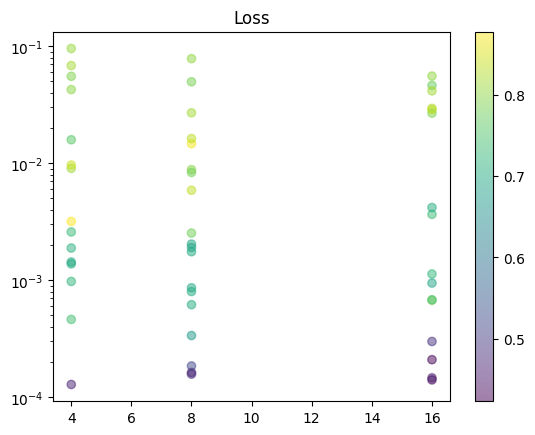

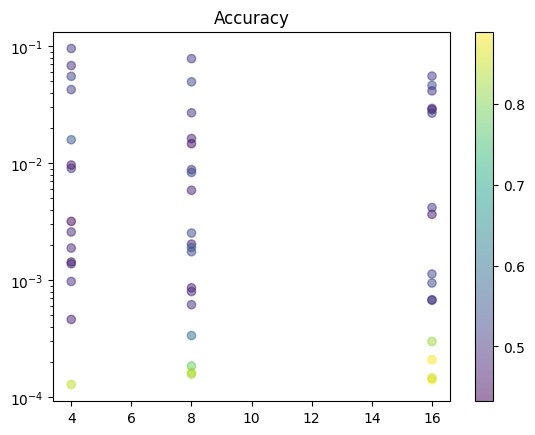

In [22]:

# read csv file

# add axis legend

# repeat for loss and accuracy

x = df['config/train_loop_config/batch_size'].values
y = df['config/train_loop_config/lr'].values

fig, ax = plt.subplots()
z = df['ptl/val_loss'].values
sc = ax.scatter(x, y, c=z, alpha=0.5)
fig.colorbar(sc)
ax.set_title('Loss')
ax.set_yscale('log')

fig, ax = plt.subplots()
z = df['ptl/val_accuracy'].values
sc = plt.scatter(x, y, c=z, alpha=0.5)
fig.colorbar(sc)
ax.set_title('Accuracy')
ax.set_yscale('log')

In [2]:
import os
import torch
import tempfile
import pytorch_lightning as pl
import torch.nn.functional as F
from filelock import FileLock
from torchmetrics import Accuracy
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms

from ray.train.lightning import (
    RayDDPStrategy,
    RayLightningEnvironment,
    RayTrainReportCallback,
    prepare_trainer,
)

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.train import RunConfig, ScalingConfig, CheckpointConfig
from ray.train.torch import TorchTrainer

import numpy as np
from pathlib import Path
from sklearn import preprocessing
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from PIL import Image
import torchvision
import torch.nn as nn

class Classifier(pl.LightningModule):
    def __init__(self, config):
        super(Classifier, self).__init__()
        self.accuracy = Accuracy(task="binary", num_classes=10, top_k=1)

        output_dim = 2

        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, output_dim)
        self.sm = nn.Softmax(dim=1)

        self.lr = config["lr"]

        self.eval_loss = []
        self.eval_accuracy = []

    def cross_entropy_loss(self, logits, labels):
        return F.nll_loss(logits, labels)

    def forward(self, x):
        x = self.model(x)
        x = self.sm(x)
        return x

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        accuracy = self.accuracy(logits, y)
        self.log("ptl/train_loss", loss)
        self.log("ptl/train_accuracy", accuracy)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        accuracy = self.accuracy(logits, y)
        self.eval_loss.append(loss)
        self.eval_accuracy.append(accuracy)
        return {"val_loss": loss, "val_accuracy": accuracy}

    def on_validation_epoch_end(self):
        avg_loss = torch.stack(self.eval_loss).mean()
        avg_acc = torch.stack(self.eval_accuracy).mean()
        self.log("ptl/val_loss", avg_loss, sync_dist=True)
        self.log("ptl/val_accuracy", avg_acc, sync_dist=True)
        self.eval_loss.clear()
        self.eval_accuracy.clear()
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer



class TrainingDataset(Dataset):
    def __init__(self, imgs,labels, transform=None):
        self.transform = transform
        self.img_list = imgs
        self.labels = labels
        #self.encoding_dict = le.classes_

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.img_list[idx]
        label = self.labels[idx]

        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image,label


class DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=128,data_dir=None):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

        self.train_transforms = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomApply([transforms.Grayscale(num_output_channels=3)], p=0.25),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
        
        self.test_transforms = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])


    def setup(self, stage=None):
        data_dir = Path(self.data_dir)
        imgs = np.array([str(p) for p in data_dir.rglob("*/*")])
        labels = np.array([Path(p).parent.name for p in imgs])
        le = preprocessing.LabelEncoder()
        _labels = le.fit_transform(labels)
        classes = le.classes_
        labels = F.one_hot(torch.from_numpy(_labels)).float()

        X_train_val, X_test, y_train_val, y_test = train_test_split(imgs, labels, test_size=0.2)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2)

        self.train_dataset = TrainingDataset(X_train,y_train,transform = self.train_transforms)
        self.val_dataset = TrainingDataset(X_val,y_val,transform = self.test_transforms)
        self.test_dataset = TrainingDataset(X_test,y_test,transform = self.test_transforms)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=1)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=1)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=1)

In [3]:
data_dir = '/storage/data/labeled_4312'

default_config = {
    "lr": 1e-3,
}

search_space = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([4, 8, 16 ]),
}

# The maximum training epochs
num_epochs = 1

# Number of sampls from parameter space
num_samples = 3


In [4]:
def train_func(config):
    dm = DataModule(batch_size=config["batch_size"],data_dir = data_dir)
    model = Classifier(config)

    trainer = pl.Trainer(
        devices="auto",
        accelerator="auto",
        strategy=RayDDPStrategy(),
        callbacks=[RayTrainReportCallback()],
        plugins=[RayLightningEnvironment()],
        enable_progress_bar=False,
    )
    trainer = prepare_trainer(trainer)
    trainer.fit(model, datamodule=dm)


scheduler = ASHAScheduler(max_t=num_epochs, grace_period=1, reduction_factor=2)

scaling_config = ScalingConfig(
    num_workers=1, use_gpu=True, resources_per_worker={"CPU": 1, "GPU": 1}
)

run_config = RunConfig(
    checkpoint_config=CheckpointConfig(
        num_to_keep=2,
        checkpoint_score_attribute="ptl/val_accuracy",
        checkpoint_score_order="max",
    ),
)

# Define a TorchTrainer without hyper-parameters for Tuner
ray_trainer = TorchTrainer(
    train_func,
    scaling_config=scaling_config,
    run_config=run_config,
)

def tune_mnist_asha(num_samples=10):
    scheduler = ASHAScheduler(max_t=num_epochs, grace_period=1, reduction_factor=2)

    tuner = tune.Tuner(
        ray_trainer,
        param_space={"train_loop_config": search_space},
        tune_config=tune.TuneConfig(
            metric="ptl/val_accuracy",
            mode="max",
            num_samples=num_samples,
            scheduler=scheduler,
        ),
    )
    return tuner.fit()


results = tune_mnist_asha(num_samples=num_samples)

(TorchTrainer pid=28260) Starting distributed worker processes: ['28307 (192.168.112.2)']
(RayTrainWorker pid=28307) Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=28307) /usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(RayTrainWorker pid=28307)   warnings.warn(
(RayTrainWorker pid=28307) /usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(RayTrainWorker pid=28307)   warnings.warn(msg)
(raylet) [2023-11-01 19:07:43,922 E 27995 28007] (raylet) file_system_monitor.cc:111: /tmp/ray

In [16]:
df = results.get_dataframe()
df

,ptl/train_loss,ptl/train_accuracy,ptl/val_loss,ptl/val_accuracy,epoch,step,timestamp,should_checkpoint,done,training_iteration,...,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,checkpoint_dir_name,config/train_loop_config/lr,config/train_loop_config/batch_size,logdir
0,1.313262,0.000000,0.834938,0.478324,0,690,1698865782,True,True,1,...,99.549214,28422,68a769195ff1,192.168.112.2,99.549214,1,checkpoint_000000,0.010882,4,ea6f7_00001
1,0.601653,0.714286,0.689309,0.545977,0,345,1698865889,True,True,1,...,103.128893,28610,68a769195ff1,192.168.112.2,103.128893,1,checkpoint_000000,0.000323,8,ea6f7_00002


(raylet) [2023-11-01 19:36:05,168 E 27995 28007] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-11-01_19-07-32_206593_27897 is over 95% full, available space: 626515968; capacity: 468438253568. Object creation will fail if spilling is required.
(raylet) [2023-11-01 19:36:15,175 E 27995 28007] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-11-01_19-07-32_206593_27897 is over 95% full, available space: 626511872; capacity: 468438253568. Object creation will fail if spilling is required.
(raylet) [2023-11-01 19:36:25,182 E 27995 28007] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-11-01_19-07-32_206593_27897 is over 95% full, available space: 626507776; capacity: 468438253568. Object creation will fail if spilling is required.
(raylet) [2023-11-01 19:36:35,189 E 27995 28007] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-11-01_19-07-32_206593_27897 is over 95% full, available space: 626466816; capacity: 468438253568. Object creation will fa

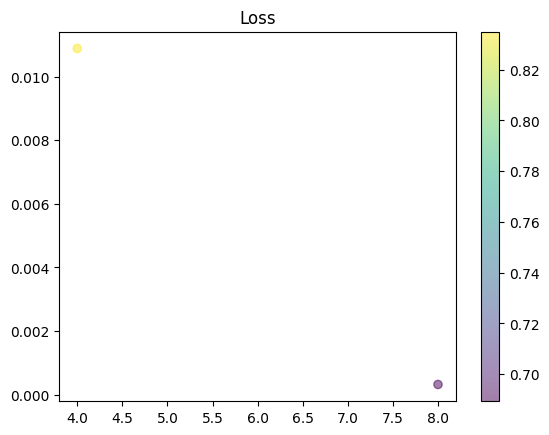

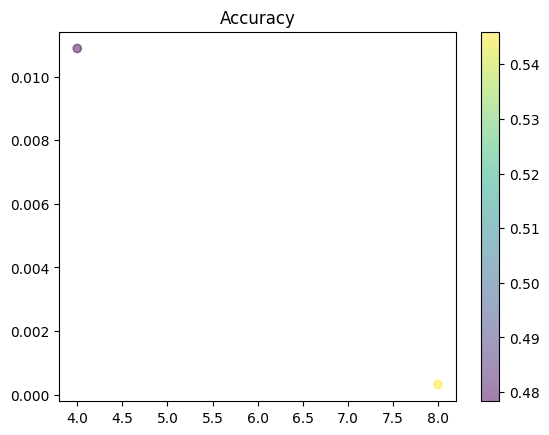

(raylet) [2023-11-01 20:20:47,160 E 27995 28007] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-11-01_19-07-32_206593_27897 is over 95% full, available space: 0; capacity: 468438253568. Object creation will fail if spilling is required.
(raylet) [2023-11-01 20:20:57,168 E 27995 28007] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-11-01_19-07-32_206593_27897 is over 95% full, available space: 0; capacity: 468438253568. Object creation will fail if spilling is required.
(raylet) [2023-11-01 20:21:07,176 E 27995 28007] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-11-01_19-07-32_206593_27897 is over 95% full, available space: 0; capacity: 468438253568. Object creation will fail if spilling is required.
(raylet) [2023-11-01 20:21:17,183 E 27995 28007] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-11-01_19-07-32_206593_27897 is over 95% full, available space: 0; capacity: 468438253568. Object creation will fail if spilling is required.
(ray

In [13]:
best_result = results.get_best_result()
loss = best_result.metrics['ptl/val_loss']
acc = best_result.metrics['ptl/val_accuracy']


(raylet) [2023-11-01 19:13:54,190 E 27995 28007] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-11-01_19-07-32_206593_27897 is over 95% full, available space: 1032425472; capacity: 468438253568. Object creation will fail if spilling is required.


In [14]:

loss

0.6893086433410645

In [15]:
acc

0.545976996421814

(raylet) [2023-11-01 19:14:04,197 E 27995 28007] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-11-01_19-07-32_206593_27897 is over 95% full, available space: 1032425472; capacity: 468438253568. Object creation will fail if spilling is required.
(raylet) [2023-11-01 19:14:14,204 E 27995 28007] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-11-01_19-07-32_206593_27897 is over 95% full, available space: 1032400896; capacity: 468438253568. Object creation will fail if spilling is required.
(raylet) [2023-11-01 19:14:24,211 E 27995 28007] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-11-01_19-07-32_206593_27897 is over 95% full, available space: 1032392704; capacity: 468438253568. Object creation will fail if spilling is required.
(raylet) [2023-11-01 19:14:34,218 E 27995 28007] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-11-01_19-07-32_206593_27897 is over 95% full, available space: 1032368128; capacity: 468438253568. Object creation wil